In [1]:
import os, importlib, sys, time

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import scipy.linalg as la
import scipy.stats as stats

# 1. parameters

In [53]:
T = 120
T0 = 20

In [54]:
GPi = np.load('EuropeCovid2_GPi.npz')

## observation parameters

In [55]:
pi = np.zeros(T+T0)
pi[:GPi['pi'].shape[0]] = GPi['pi']
alpha = 1
s_eps = 138

$$Y_t = \alpha \sum_{s=1}^{t-1} I_s g_{t-s} + \epsilon_t$$

$$\epsilon_t \sim N(0,\sigma_\epsilon^2)$$

## latent parameters

In [56]:
g = np.zeros(T+T0)
g[:GPi['g'].shape[0]] = GPi['g']

In [57]:
d = 2
beta = [0.2, 1.8]
K = 6.5

$$I_0 = \mu + \eta_0$$

$$I_t = R(\bar{A}_t, \beta) \sum_{s=1}^{t-1}I_s \pi_{t-s} + \eta_t, ~~ t \geq 1$$

$$\eta_t \sim N(0,\sigma_\eta^2)$$

$$R(\bar{A}_t, \beta) = \frac{K}{1+\exp(\beta \sum_{s=1}^{t-1}A_s h_{t-s})}$$

## seed values

In [58]:
mu_0 = 18

# 2. simulation

In [59]:
R = np.zeros(T+T0)
I = np.zeros(T+T0)
A = np.zeros([T+T0, d])
Y = np.zeros(T)

## initialization

In [60]:
A[0] = [1, 0]
R[0] = K / (1 + np.exp(beta @ A[0]))
I[0] = mu_0

## iteration

In [73]:
for t in np.arange(1,T+T0):
    A[t] = [1, 1 * (t > 36)]
    R[t] = K / (1 + np.exp(beta @ A[t]))
    I[t] = R[t] * np.sum(np.flip(I[:t])*g[:t])

In [74]:
for t in np.arange(T):
    Y[t] = alpha * np.sum(np.flip(I[:t+T0])*pi[:t+T0]) + np.random.normal(0,s_eps)

## result

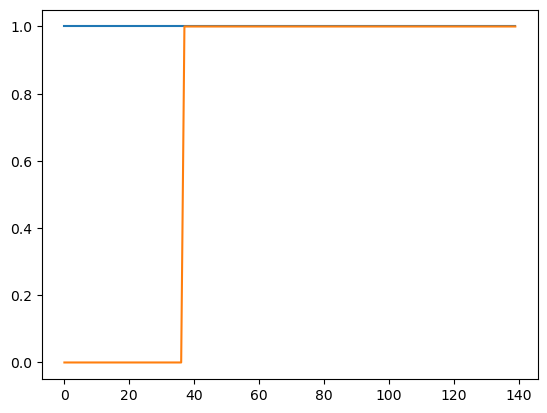

In [75]:
plt.plot(A)

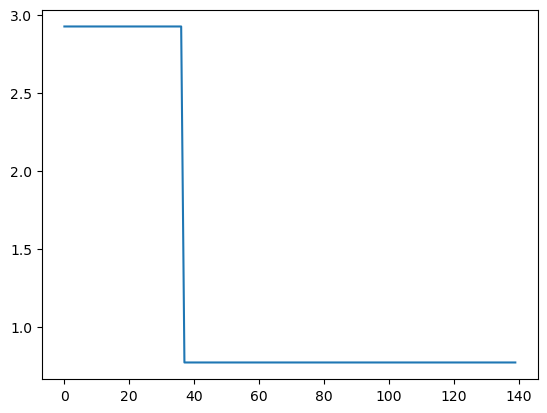

In [76]:
plt.plot(R)

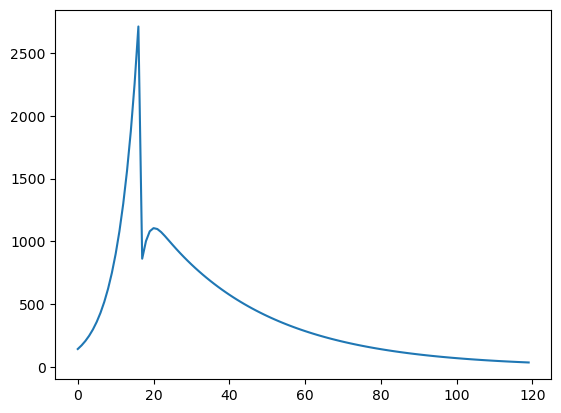

In [77]:
plt.plot(I[T0:])

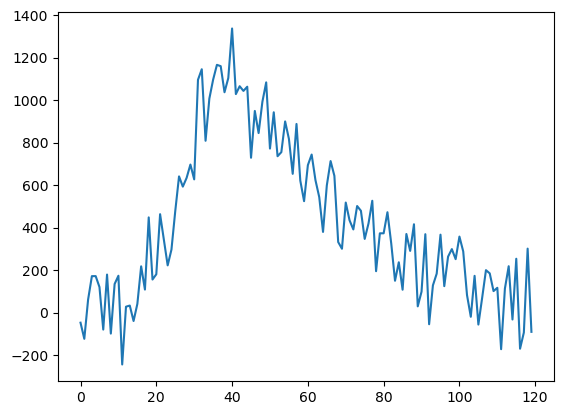

In [78]:
plt.plot(Y)

# 3. fit by EM algorithm

In [87]:
def fit(obs, minit_0, sinit_eps, binit,
        n_iter=3000, history=False, verbose=False):
    
    mhat_0=minit_0
    shat_eps = sinit_eps
    bhat=binit
    
    mhat = np.concatenate([[mhat_0], np.zeros(T+T0-1)])
    
    if history:
        mhs_0 = np.zeros(n_iter)
        shs_eps = np.zeros(n_iter)
        bhs = np.zeros([n_iter, d])
        
    Rhat = np.zeros(T+T0)
    d1Rh = np.zeros([d, T+T0])
    d2Rh = np.zeros([d, d, T+T0])
    
    for t in np.arange(T+T0):
        o = np.exp(bhat @ A[t])
        p = 1 / (1 + o)
        q = o / (1 + o)

        Rhat[t] = K * p
        d1Rh[:,t] = - K * p * q * A[t]
        d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

    Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
    G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
    inv_ImG = la.inv(np.eye(T+T0)-G)
    
    EY = (Pi @ (inv_ImG @ mhat[:,None]))[...,0]
    shat_eps = np.sqrt(np.sum((obs-EY)**2)/T)
    
    if verbose:
        print("Before EM, shat_eps: %f"%shat_eps)
    
    for i in np.arange(n_iter):
        start_iter = time.time()

        # iteration for mu
        mhat_0 = (obs @ Pi @ inv_ImG[:,0]) / np.sum((Pi @ inv_ImG[:,0])**2)
        mhat = np.concatenate([[mhat_0], np.zeros(T+T0-1)])
        
        # iteration for beta
        d1G = d1Rh[:,:,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        d2G = d2Rh[...,None] * np.concatenate([[0],g])[
                np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        
        EY = (Pi @ (inv_ImG @ mhat[:,None]))[...,0]
        d1EY = (Pi @ (inv_ImG @ (d1G @ (inv_ImG @ mhat[:,None]))))[...,0]
        d2EY = (Pi @ (inv_ImG @ d1G[:,None] @ inv_ImG @ d1G @ inv_ImG
                      + inv_ImG @ d1G @ inv_ImG @ d1G[:,None] @ inv_ImG
                      + inv_ImG @ d2G @ inv_ImG) @ mhat[:,None])[...,0]
        
        d1f = - (2/(T+T0)/shat_eps**2) * d1EY @ (obs - EY)
        d2f = (2/(T+T0)/shat_eps**2) * (d1EY @ d1EY.T - d2EY @ (obs-EY))
        
        u, v = la.eig(d2f)
        db = np.real(((v/np.maximum(u,np.max(u)/100)) @ v.T) @ d1f)
        ss = np.min([1, 0.3/np.sqrt(np.sum(db**2))])
        bhat = bhat - ss * db
        
        for t in np.arange(T+T0):
            o = np.exp(bhat @ A[t])
            p = 1 / (1 + o)
            q = o / (1 + o)

            Rhat[t] = K * p
            d1Rh[:,t] = - K * p * q * A[t]
            d2Rh[:,:,t] = K * p * q * (q - p) * (A[t,:,None] * A[t])

        Pi = alpha * np.concatenate([[0],pi])[np.maximum(0, T0 + np.arange(T)[:,None] - np.arange(T+T0))]
        G = Rhat[:,None] * np.concatenate([[0],g])[np.maximum(0, np.arange(T+T0)[:,None] - np.arange(T+T0))]
        inv_ImG = la.inv(np.eye(T+T0)-G)
    
        EY = (Pi @ (inv_ImG @ mhat[:,None]))[...,0]
        shat_eps = np.sqrt(np.sum((obs-EY)**2)/T)
    
        if history:
            mhs_0[i] = mhat_0
            shs_eps[i] = shat_eps
            bhs[i] = bhat
        
        if verbose:
            print("%d-th iteration finished, shat_eps: %f, lapse: %.3fsec."
                  %(i+1, shat_eps, time.time()-start_iter))
            
    if history:
        return mhs_0, shs_eps, bhs
    else:
        return mhat_0, shat_eps, bhat

In [88]:
mhs_0, shs_eps, bhs =\
    fit(Y, mu_0, s_eps, beta, history=True, verbose=True, n_iter=3000)

Before EM, shat_eps: 130.553337
1-th iteration finished, shat_eps: 129.289374, lapse: 0.010sec.
2-th iteration finished, shat_eps: 129.280600, lapse: 0.009sec.
3-th iteration finished, shat_eps: 129.280592, lapse: 0.008sec.
4-th iteration finished, shat_eps: 129.280586, lapse: 0.008sec.
5-th iteration finished, shat_eps: 129.280581, lapse: 0.007sec.
6-th iteration finished, shat_eps: 129.280575, lapse: 0.011sec.
7-th iteration finished, shat_eps: 129.280569, lapse: 0.006sec.
8-th iteration finished, shat_eps: 129.280564, lapse: 0.005sec.
9-th iteration finished, shat_eps: 129.280558, lapse: 0.006sec.
10-th iteration finished, shat_eps: 129.280552, lapse: 0.006sec.
11-th iteration finished, shat_eps: 129.280547, lapse: 0.006sec.
12-th iteration finished, shat_eps: 129.280541, lapse: 0.005sec.
13-th iteration finished, shat_eps: 129.280535, lapse: 0.006sec.
14-th iteration finished, shat_eps: 129.280530, lapse: 0.007sec.
15-th iteration finished, shat_eps: 129.280524, lapse: 0.006sec.
16

140-th iteration finished, shat_eps: 129.279889, lapse: 0.014sec.
141-th iteration finished, shat_eps: 129.279885, lapse: 0.022sec.
142-th iteration finished, shat_eps: 129.279880, lapse: 0.010sec.
143-th iteration finished, shat_eps: 129.279875, lapse: 0.008sec.
144-th iteration finished, shat_eps: 129.279871, lapse: 0.017sec.
145-th iteration finished, shat_eps: 129.279866, lapse: 0.009sec.
146-th iteration finished, shat_eps: 129.279862, lapse: 0.005sec.
147-th iteration finished, shat_eps: 129.279857, lapse: 0.009sec.
148-th iteration finished, shat_eps: 129.279853, lapse: 0.006sec.
149-th iteration finished, shat_eps: 129.279848, lapse: 0.006sec.
150-th iteration finished, shat_eps: 129.279844, lapse: 0.007sec.
151-th iteration finished, shat_eps: 129.279839, lapse: 0.005sec.
152-th iteration finished, shat_eps: 129.279835, lapse: 0.004sec.
153-th iteration finished, shat_eps: 129.279830, lapse: 0.010sec.
154-th iteration finished, shat_eps: 129.279826, lapse: 0.007sec.
155-th ite

268-th iteration finished, shat_eps: 129.279360, lapse: 0.011sec.
269-th iteration finished, shat_eps: 129.279356, lapse: 0.014sec.
270-th iteration finished, shat_eps: 129.279353, lapse: 0.006sec.
271-th iteration finished, shat_eps: 129.279349, lapse: 0.014sec.
272-th iteration finished, shat_eps: 129.279345, lapse: 0.013sec.
273-th iteration finished, shat_eps: 129.279342, lapse: 0.009sec.
274-th iteration finished, shat_eps: 129.279338, lapse: 0.010sec.
275-th iteration finished, shat_eps: 129.279334, lapse: 0.009sec.
276-th iteration finished, shat_eps: 129.279331, lapse: 0.007sec.
277-th iteration finished, shat_eps: 129.279327, lapse: 0.005sec.
278-th iteration finished, shat_eps: 129.279323, lapse: 0.005sec.
279-th iteration finished, shat_eps: 129.279320, lapse: 0.005sec.
280-th iteration finished, shat_eps: 129.279316, lapse: 0.014sec.
281-th iteration finished, shat_eps: 129.279312, lapse: 0.005sec.
282-th iteration finished, shat_eps: 129.279309, lapse: 0.005sec.
283-th ite

402-th iteration finished, shat_eps: 129.278912, lapse: 0.017sec.
403-th iteration finished, shat_eps: 129.278909, lapse: 0.018sec.
404-th iteration finished, shat_eps: 129.278906, lapse: 0.005sec.
405-th iteration finished, shat_eps: 129.278903, lapse: 0.012sec.
406-th iteration finished, shat_eps: 129.278901, lapse: 0.004sec.
407-th iteration finished, shat_eps: 129.278898, lapse: 0.010sec.
408-th iteration finished, shat_eps: 129.278895, lapse: 0.005sec.
409-th iteration finished, shat_eps: 129.278892, lapse: 0.005sec.
410-th iteration finished, shat_eps: 129.278889, lapse: 0.005sec.
411-th iteration finished, shat_eps: 129.278886, lapse: 0.005sec.
412-th iteration finished, shat_eps: 129.278883, lapse: 0.008sec.
413-th iteration finished, shat_eps: 129.278880, lapse: 0.007sec.
414-th iteration finished, shat_eps: 129.278877, lapse: 0.005sec.
415-th iteration finished, shat_eps: 129.278874, lapse: 0.013sec.
416-th iteration finished, shat_eps: 129.278871, lapse: 0.006sec.
417-th ite

529-th iteration finished, shat_eps: 129.278569, lapse: 0.012sec.
530-th iteration finished, shat_eps: 129.278567, lapse: 0.018sec.
531-th iteration finished, shat_eps: 129.278564, lapse: 0.009sec.
532-th iteration finished, shat_eps: 129.278562, lapse: 0.013sec.
533-th iteration finished, shat_eps: 129.278559, lapse: 0.008sec.
534-th iteration finished, shat_eps: 129.278557, lapse: 0.007sec.
535-th iteration finished, shat_eps: 129.278554, lapse: 0.006sec.
536-th iteration finished, shat_eps: 129.278552, lapse: 0.007sec.
537-th iteration finished, shat_eps: 129.278550, lapse: 0.006sec.
538-th iteration finished, shat_eps: 129.278547, lapse: 0.007sec.
539-th iteration finished, shat_eps: 129.278545, lapse: 0.007sec.
540-th iteration finished, shat_eps: 129.278542, lapse: 0.006sec.
541-th iteration finished, shat_eps: 129.278540, lapse: 0.006sec.
542-th iteration finished, shat_eps: 129.278538, lapse: 0.006sec.
543-th iteration finished, shat_eps: 129.278535, lapse: 0.006sec.
544-th ite

659-th iteration finished, shat_eps: 129.278283, lapse: 0.014sec.
660-th iteration finished, shat_eps: 129.278281, lapse: 0.015sec.
661-th iteration finished, shat_eps: 129.278279, lapse: 0.013sec.
662-th iteration finished, shat_eps: 129.278277, lapse: 0.022sec.
663-th iteration finished, shat_eps: 129.278275, lapse: 0.024sec.
664-th iteration finished, shat_eps: 129.278273, lapse: 0.019sec.
665-th iteration finished, shat_eps: 129.278271, lapse: 0.007sec.
666-th iteration finished, shat_eps: 129.278269, lapse: 0.010sec.
667-th iteration finished, shat_eps: 129.278267, lapse: 0.008sec.
668-th iteration finished, shat_eps: 129.278265, lapse: 0.011sec.
669-th iteration finished, shat_eps: 129.278264, lapse: 0.005sec.
670-th iteration finished, shat_eps: 129.278262, lapse: 0.012sec.
671-th iteration finished, shat_eps: 129.278260, lapse: 0.010sec.
672-th iteration finished, shat_eps: 129.278258, lapse: 0.010sec.
673-th iteration finished, shat_eps: 129.278256, lapse: 0.009sec.
674-th ite

796-th iteration finished, shat_eps: 129.278040, lapse: 0.019sec.
797-th iteration finished, shat_eps: 129.278038, lapse: 0.012sec.
798-th iteration finished, shat_eps: 129.278037, lapse: 0.005sec.
799-th iteration finished, shat_eps: 129.278035, lapse: 0.006sec.
800-th iteration finished, shat_eps: 129.278034, lapse: 0.011sec.
801-th iteration finished, shat_eps: 129.278032, lapse: 0.007sec.
802-th iteration finished, shat_eps: 129.278031, lapse: 0.007sec.
803-th iteration finished, shat_eps: 129.278029, lapse: 0.006sec.
804-th iteration finished, shat_eps: 129.278027, lapse: 0.005sec.
805-th iteration finished, shat_eps: 129.278026, lapse: 0.006sec.
806-th iteration finished, shat_eps: 129.278024, lapse: 0.008sec.
807-th iteration finished, shat_eps: 129.278023, lapse: 0.008sec.
808-th iteration finished, shat_eps: 129.278021, lapse: 0.010sec.
809-th iteration finished, shat_eps: 129.278020, lapse: 0.007sec.
810-th iteration finished, shat_eps: 129.278018, lapse: 0.015sec.
811-th ite

935-th iteration finished, shat_eps: 129.277842, lapse: 0.017sec.
936-th iteration finished, shat_eps: 129.277841, lapse: 0.009sec.
937-th iteration finished, shat_eps: 129.277840, lapse: 0.005sec.
938-th iteration finished, shat_eps: 129.277839, lapse: 0.008sec.
939-th iteration finished, shat_eps: 129.277837, lapse: 0.005sec.
940-th iteration finished, shat_eps: 129.277836, lapse: 0.008sec.
941-th iteration finished, shat_eps: 129.277835, lapse: 0.005sec.
942-th iteration finished, shat_eps: 129.277833, lapse: 0.008sec.
943-th iteration finished, shat_eps: 129.277832, lapse: 0.005sec.
944-th iteration finished, shat_eps: 129.277831, lapse: 0.009sec.
945-th iteration finished, shat_eps: 129.277830, lapse: 0.005sec.
946-th iteration finished, shat_eps: 129.277828, lapse: 0.005sec.
947-th iteration finished, shat_eps: 129.277827, lapse: 0.017sec.
948-th iteration finished, shat_eps: 129.277826, lapse: 0.011sec.
949-th iteration finished, shat_eps: 129.277825, lapse: 0.013sec.
950-th ite

1070-th iteration finished, shat_eps: 129.277688, lapse: 0.014sec.
1071-th iteration finished, shat_eps: 129.277687, lapse: 0.018sec.
1072-th iteration finished, shat_eps: 129.277686, lapse: 0.014sec.
1073-th iteration finished, shat_eps: 129.277685, lapse: 0.035sec.
1074-th iteration finished, shat_eps: 129.277684, lapse: 0.008sec.
1075-th iteration finished, shat_eps: 129.277683, lapse: 0.012sec.
1076-th iteration finished, shat_eps: 129.277682, lapse: 0.026sec.
1077-th iteration finished, shat_eps: 129.277681, lapse: 0.008sec.
1078-th iteration finished, shat_eps: 129.277680, lapse: 0.013sec.
1079-th iteration finished, shat_eps: 129.277679, lapse: 0.010sec.
1080-th iteration finished, shat_eps: 129.277678, lapse: 0.011sec.
1081-th iteration finished, shat_eps: 129.277677, lapse: 0.012sec.
1082-th iteration finished, shat_eps: 129.277676, lapse: 0.010sec.
1083-th iteration finished, shat_eps: 129.277675, lapse: 0.007sec.
1084-th iteration finished, shat_eps: 129.277674, lapse: 0.005

1200-th iteration finished, shat_eps: 129.277568, lapse: 0.015sec.
1201-th iteration finished, shat_eps: 129.277567, lapse: 0.012sec.
1202-th iteration finished, shat_eps: 129.277566, lapse: 0.014sec.
1203-th iteration finished, shat_eps: 129.277565, lapse: 0.012sec.
1204-th iteration finished, shat_eps: 129.277564, lapse: 0.012sec.
1205-th iteration finished, shat_eps: 129.277564, lapse: 0.006sec.
1206-th iteration finished, shat_eps: 129.277563, lapse: 0.005sec.
1207-th iteration finished, shat_eps: 129.277562, lapse: 0.011sec.
1208-th iteration finished, shat_eps: 129.277561, lapse: 0.010sec.
1209-th iteration finished, shat_eps: 129.277560, lapse: 0.011sec.
1210-th iteration finished, shat_eps: 129.277560, lapse: 0.016sec.
1211-th iteration finished, shat_eps: 129.277559, lapse: 0.006sec.
1212-th iteration finished, shat_eps: 129.277558, lapse: 0.017sec.
1213-th iteration finished, shat_eps: 129.277557, lapse: 0.009sec.
1214-th iteration finished, shat_eps: 129.277556, lapse: 0.006

1326-th iteration finished, shat_eps: 129.277473, lapse: 0.017sec.
1327-th iteration finished, shat_eps: 129.277472, lapse: 0.009sec.
1328-th iteration finished, shat_eps: 129.277471, lapse: 0.006sec.
1329-th iteration finished, shat_eps: 129.277471, lapse: 0.014sec.
1330-th iteration finished, shat_eps: 129.277470, lapse: 0.012sec.
1331-th iteration finished, shat_eps: 129.277469, lapse: 0.012sec.
1332-th iteration finished, shat_eps: 129.277469, lapse: 0.007sec.
1333-th iteration finished, shat_eps: 129.277468, lapse: 0.013sec.
1334-th iteration finished, shat_eps: 129.277467, lapse: 0.009sec.
1335-th iteration finished, shat_eps: 129.277467, lapse: 0.014sec.
1336-th iteration finished, shat_eps: 129.277466, lapse: 0.012sec.
1337-th iteration finished, shat_eps: 129.277465, lapse: 0.007sec.
1338-th iteration finished, shat_eps: 129.277465, lapse: 0.011sec.
1339-th iteration finished, shat_eps: 129.277464, lapse: 0.005sec.
1340-th iteration finished, shat_eps: 129.277463, lapse: 0.009

1450-th iteration finished, shat_eps: 129.277396, lapse: 0.012sec.
1451-th iteration finished, shat_eps: 129.277395, lapse: 0.018sec.
1452-th iteration finished, shat_eps: 129.277395, lapse: 0.010sec.
1453-th iteration finished, shat_eps: 129.277394, lapse: 0.005sec.
1454-th iteration finished, shat_eps: 129.277394, lapse: 0.006sec.
1455-th iteration finished, shat_eps: 129.277393, lapse: 0.011sec.
1456-th iteration finished, shat_eps: 129.277393, lapse: 0.007sec.
1457-th iteration finished, shat_eps: 129.277392, lapse: 0.076sec.
1458-th iteration finished, shat_eps: 129.277392, lapse: 0.011sec.
1459-th iteration finished, shat_eps: 129.277391, lapse: 0.010sec.
1460-th iteration finished, shat_eps: 129.277390, lapse: 0.013sec.
1461-th iteration finished, shat_eps: 129.277390, lapse: 0.011sec.
1462-th iteration finished, shat_eps: 129.277389, lapse: 0.054sec.
1463-th iteration finished, shat_eps: 129.277389, lapse: 0.017sec.
1464-th iteration finished, shat_eps: 129.277388, lapse: 0.007

1584-th iteration finished, shat_eps: 129.277328, lapse: 0.016sec.
1585-th iteration finished, shat_eps: 129.277328, lapse: 0.013sec.
1586-th iteration finished, shat_eps: 129.277327, lapse: 0.007sec.
1587-th iteration finished, shat_eps: 129.277327, lapse: 0.008sec.
1588-th iteration finished, shat_eps: 129.277327, lapse: 0.017sec.
1589-th iteration finished, shat_eps: 129.277326, lapse: 0.008sec.
1590-th iteration finished, shat_eps: 129.277326, lapse: 0.007sec.
1591-th iteration finished, shat_eps: 129.277325, lapse: 0.009sec.
1592-th iteration finished, shat_eps: 129.277325, lapse: 0.006sec.
1593-th iteration finished, shat_eps: 129.277324, lapse: 0.006sec.
1594-th iteration finished, shat_eps: 129.277324, lapse: 0.012sec.
1595-th iteration finished, shat_eps: 129.277323, lapse: 0.005sec.
1596-th iteration finished, shat_eps: 129.277323, lapse: 0.006sec.
1597-th iteration finished, shat_eps: 129.277323, lapse: 0.008sec.
1598-th iteration finished, shat_eps: 129.277322, lapse: 0.006

1720-th iteration finished, shat_eps: 129.277273, lapse: 0.011sec.
1721-th iteration finished, shat_eps: 129.277273, lapse: 0.012sec.
1722-th iteration finished, shat_eps: 129.277272, lapse: 0.006sec.
1723-th iteration finished, shat_eps: 129.277272, lapse: 0.007sec.
1724-th iteration finished, shat_eps: 129.277272, lapse: 0.004sec.
1725-th iteration finished, shat_eps: 129.277271, lapse: 0.005sec.
1726-th iteration finished, shat_eps: 129.277271, lapse: 0.009sec.
1727-th iteration finished, shat_eps: 129.277270, lapse: 0.005sec.
1728-th iteration finished, shat_eps: 129.277270, lapse: 0.005sec.
1729-th iteration finished, shat_eps: 129.277270, lapse: 0.006sec.
1730-th iteration finished, shat_eps: 129.277269, lapse: 0.010sec.
1731-th iteration finished, shat_eps: 129.277269, lapse: 0.007sec.
1732-th iteration finished, shat_eps: 129.277269, lapse: 0.009sec.
1733-th iteration finished, shat_eps: 129.277268, lapse: 0.006sec.
1734-th iteration finished, shat_eps: 129.277268, lapse: 0.023

1867-th iteration finished, shat_eps: 129.277225, lapse: 0.006sec.
1868-th iteration finished, shat_eps: 129.277225, lapse: 0.023sec.
1869-th iteration finished, shat_eps: 129.277224, lapse: 0.012sec.
1870-th iteration finished, shat_eps: 129.277224, lapse: 0.006sec.
1871-th iteration finished, shat_eps: 129.277224, lapse: 0.027sec.
1872-th iteration finished, shat_eps: 129.277224, lapse: 0.008sec.
1873-th iteration finished, shat_eps: 129.277223, lapse: 0.021sec.
1874-th iteration finished, shat_eps: 129.277223, lapse: 0.015sec.
1875-th iteration finished, shat_eps: 129.277223, lapse: 0.006sec.
1876-th iteration finished, shat_eps: 129.277222, lapse: 0.011sec.
1877-th iteration finished, shat_eps: 129.277222, lapse: 0.017sec.
1878-th iteration finished, shat_eps: 129.277222, lapse: 0.011sec.
1879-th iteration finished, shat_eps: 129.277222, lapse: 0.006sec.
1880-th iteration finished, shat_eps: 129.277221, lapse: 0.007sec.
1881-th iteration finished, shat_eps: 129.277221, lapse: 0.013

2001-th iteration finished, shat_eps: 129.277190, lapse: 0.015sec.
2002-th iteration finished, shat_eps: 129.277190, lapse: 0.017sec.
2003-th iteration finished, shat_eps: 129.277190, lapse: 0.008sec.
2004-th iteration finished, shat_eps: 129.277189, lapse: 0.005sec.
2005-th iteration finished, shat_eps: 129.277189, lapse: 0.006sec.
2006-th iteration finished, shat_eps: 129.277189, lapse: 0.011sec.
2007-th iteration finished, shat_eps: 129.277189, lapse: 0.024sec.
2008-th iteration finished, shat_eps: 129.277188, lapse: 0.008sec.
2009-th iteration finished, shat_eps: 129.277188, lapse: 0.007sec.
2010-th iteration finished, shat_eps: 129.277188, lapse: 0.005sec.
2011-th iteration finished, shat_eps: 129.277188, lapse: 0.005sec.
2012-th iteration finished, shat_eps: 129.277188, lapse: 0.006sec.
2013-th iteration finished, shat_eps: 129.277187, lapse: 0.007sec.
2014-th iteration finished, shat_eps: 129.277187, lapse: 0.005sec.
2015-th iteration finished, shat_eps: 129.277187, lapse: 0.010

2144-th iteration finished, shat_eps: 129.277160, lapse: 0.025sec.
2145-th iteration finished, shat_eps: 129.277160, lapse: 0.015sec.
2146-th iteration finished, shat_eps: 129.277160, lapse: 0.008sec.
2147-th iteration finished, shat_eps: 129.277160, lapse: 0.019sec.
2148-th iteration finished, shat_eps: 129.277159, lapse: 0.007sec.
2149-th iteration finished, shat_eps: 129.277159, lapse: 0.017sec.
2150-th iteration finished, shat_eps: 129.277159, lapse: 0.013sec.
2151-th iteration finished, shat_eps: 129.277159, lapse: 0.008sec.
2152-th iteration finished, shat_eps: 129.277159, lapse: 0.015sec.
2153-th iteration finished, shat_eps: 129.277158, lapse: 0.010sec.
2154-th iteration finished, shat_eps: 129.277158, lapse: 0.008sec.
2155-th iteration finished, shat_eps: 129.277158, lapse: 0.015sec.
2156-th iteration finished, shat_eps: 129.277158, lapse: 0.011sec.
2157-th iteration finished, shat_eps: 129.277158, lapse: 0.011sec.
2158-th iteration finished, shat_eps: 129.277157, lapse: 0.009

2281-th iteration finished, shat_eps: 129.277137, lapse: 0.021sec.
2282-th iteration finished, shat_eps: 129.277137, lapse: 0.036sec.
2283-th iteration finished, shat_eps: 129.277137, lapse: 0.007sec.
2284-th iteration finished, shat_eps: 129.277137, lapse: 0.012sec.
2285-th iteration finished, shat_eps: 129.277136, lapse: 0.011sec.
2286-th iteration finished, shat_eps: 129.277136, lapse: 0.006sec.
2287-th iteration finished, shat_eps: 129.277136, lapse: 0.013sec.
2288-th iteration finished, shat_eps: 129.277136, lapse: 0.008sec.
2289-th iteration finished, shat_eps: 129.277136, lapse: 0.016sec.
2290-th iteration finished, shat_eps: 129.277136, lapse: 0.009sec.
2291-th iteration finished, shat_eps: 129.277136, lapse: 0.005sec.
2292-th iteration finished, shat_eps: 129.277135, lapse: 0.012sec.
2293-th iteration finished, shat_eps: 129.277135, lapse: 0.008sec.
2294-th iteration finished, shat_eps: 129.277135, lapse: 0.011sec.
2295-th iteration finished, shat_eps: 129.277135, lapse: 0.006

2425-th iteration finished, shat_eps: 129.277118, lapse: 0.018sec.
2426-th iteration finished, shat_eps: 129.277117, lapse: 0.013sec.
2427-th iteration finished, shat_eps: 129.277117, lapse: 0.005sec.
2428-th iteration finished, shat_eps: 129.277117, lapse: 0.012sec.
2429-th iteration finished, shat_eps: 129.277117, lapse: 0.005sec.
2430-th iteration finished, shat_eps: 129.277117, lapse: 0.012sec.
2431-th iteration finished, shat_eps: 129.277117, lapse: 0.005sec.
2432-th iteration finished, shat_eps: 129.277117, lapse: 0.005sec.
2433-th iteration finished, shat_eps: 129.277117, lapse: 0.008sec.
2434-th iteration finished, shat_eps: 129.277116, lapse: 0.006sec.
2435-th iteration finished, shat_eps: 129.277116, lapse: 0.005sec.
2436-th iteration finished, shat_eps: 129.277116, lapse: 0.008sec.
2437-th iteration finished, shat_eps: 129.277116, lapse: 0.007sec.
2438-th iteration finished, shat_eps: 129.277116, lapse: 0.005sec.
2439-th iteration finished, shat_eps: 129.277116, lapse: 0.006

2575-th iteration finished, shat_eps: 129.277101, lapse: 0.022sec.
2576-th iteration finished, shat_eps: 129.277101, lapse: 0.009sec.
2577-th iteration finished, shat_eps: 129.277101, lapse: 0.039sec.
2578-th iteration finished, shat_eps: 129.277101, lapse: 0.015sec.
2579-th iteration finished, shat_eps: 129.277101, lapse: 0.007sec.
2580-th iteration finished, shat_eps: 129.277101, lapse: 0.009sec.
2581-th iteration finished, shat_eps: 129.277101, lapse: 0.005sec.
2582-th iteration finished, shat_eps: 129.277101, lapse: 0.009sec.
2583-th iteration finished, shat_eps: 129.277101, lapse: 0.010sec.
2584-th iteration finished, shat_eps: 129.277101, lapse: 0.006sec.
2585-th iteration finished, shat_eps: 129.277101, lapse: 0.005sec.
2586-th iteration finished, shat_eps: 129.277100, lapse: 0.006sec.
2587-th iteration finished, shat_eps: 129.277100, lapse: 0.008sec.
2588-th iteration finished, shat_eps: 129.277100, lapse: 0.005sec.
2589-th iteration finished, shat_eps: 129.277100, lapse: 0.005

2709-th iteration finished, shat_eps: 129.277090, lapse: 0.007sec.
2710-th iteration finished, shat_eps: 129.277090, lapse: 0.028sec.
2711-th iteration finished, shat_eps: 129.277090, lapse: 0.007sec.
2712-th iteration finished, shat_eps: 129.277090, lapse: 0.006sec.
2713-th iteration finished, shat_eps: 129.277090, lapse: 0.008sec.
2714-th iteration finished, shat_eps: 129.277090, lapse: 0.004sec.
2715-th iteration finished, shat_eps: 129.277090, lapse: 0.008sec.
2716-th iteration finished, shat_eps: 129.277089, lapse: 0.005sec.
2717-th iteration finished, shat_eps: 129.277089, lapse: 0.004sec.
2718-th iteration finished, shat_eps: 129.277089, lapse: 0.028sec.
2719-th iteration finished, shat_eps: 129.277089, lapse: 0.018sec.
2720-th iteration finished, shat_eps: 129.277089, lapse: 0.010sec.
2721-th iteration finished, shat_eps: 129.277089, lapse: 0.009sec.
2722-th iteration finished, shat_eps: 129.277089, lapse: 0.012sec.
2723-th iteration finished, shat_eps: 129.277089, lapse: 0.008

2833-th iteration finished, shat_eps: 129.277081, lapse: 0.010sec.
2834-th iteration finished, shat_eps: 129.277081, lapse: 0.024sec.
2835-th iteration finished, shat_eps: 129.277081, lapse: 0.019sec.
2836-th iteration finished, shat_eps: 129.277081, lapse: 0.016sec.
2837-th iteration finished, shat_eps: 129.277081, lapse: 0.015sec.
2838-th iteration finished, shat_eps: 129.277081, lapse: 0.032sec.
2839-th iteration finished, shat_eps: 129.277081, lapse: 0.019sec.
2840-th iteration finished, shat_eps: 129.277081, lapse: 0.011sec.
2841-th iteration finished, shat_eps: 129.277081, lapse: 0.021sec.
2842-th iteration finished, shat_eps: 129.277081, lapse: 0.015sec.
2843-th iteration finished, shat_eps: 129.277081, lapse: 0.009sec.
2844-th iteration finished, shat_eps: 129.277081, lapse: 0.015sec.
2845-th iteration finished, shat_eps: 129.277081, lapse: 0.015sec.
2846-th iteration finished, shat_eps: 129.277081, lapse: 0.026sec.
2847-th iteration finished, shat_eps: 129.277080, lapse: 0.012

2964-th iteration finished, shat_eps: 129.277074, lapse: 0.024sec.
2965-th iteration finished, shat_eps: 129.277074, lapse: 0.022sec.
2966-th iteration finished, shat_eps: 129.277074, lapse: 0.009sec.
2967-th iteration finished, shat_eps: 129.277074, lapse: 0.013sec.
2968-th iteration finished, shat_eps: 129.277074, lapse: 0.008sec.
2969-th iteration finished, shat_eps: 129.277074, lapse: 0.008sec.
2970-th iteration finished, shat_eps: 129.277074, lapse: 0.008sec.
2971-th iteration finished, shat_eps: 129.277073, lapse: 0.007sec.
2972-th iteration finished, shat_eps: 129.277073, lapse: 0.007sec.
2973-th iteration finished, shat_eps: 129.277073, lapse: 0.007sec.
2974-th iteration finished, shat_eps: 129.277073, lapse: 0.005sec.
2975-th iteration finished, shat_eps: 129.277073, lapse: 0.006sec.
2976-th iteration finished, shat_eps: 129.277073, lapse: 0.007sec.
2977-th iteration finished, shat_eps: 129.277073, lapse: 0.006sec.
2978-th iteration finished, shat_eps: 129.277073, lapse: 0.005

In [89]:
mmle_0 = mhs_0[-1]
smle_eps = shs_eps[-1]
bmle = bhs[-1]

## plots

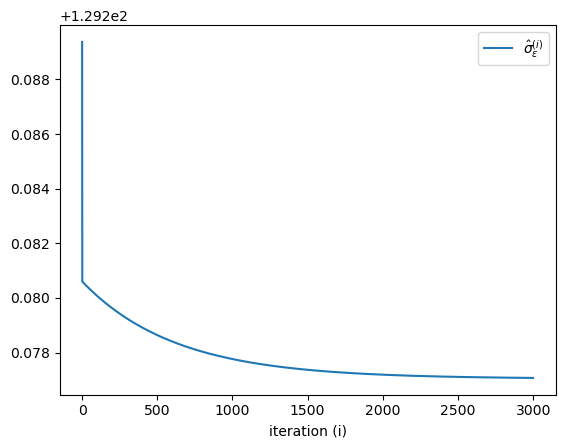

In [90]:
plt.plot(shs_eps, label=r"$\hat{\sigma}^{(i)}_\epsilon$")
# plt.plot(shs_eta, label=r"$\hat{\sigma}^{(i)}_\eta$")
plt.xlabel("iteration (i)"); plt.legend()

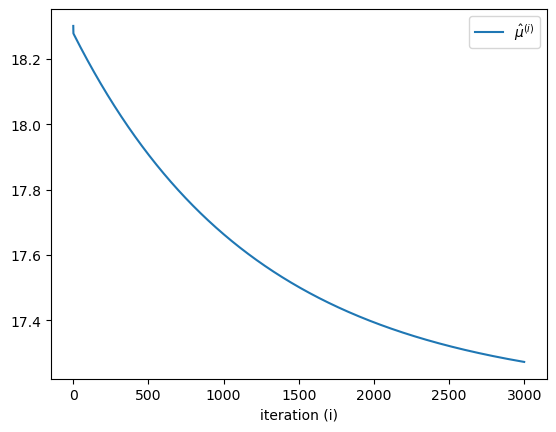

In [91]:
plt.plot(mhs_0, label=r"$\hat{\mu}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

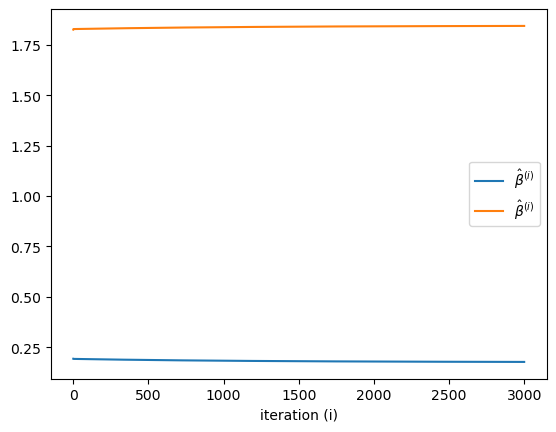

In [92]:
plt.plot(bhs, label=r"$\hat{\beta}^{(i)}$")
plt.xlabel("iteration (i)"); plt.legend()

# 4. Simulation Study

In [93]:
num_sim = 200
num_iter = 100

In [94]:
msim_0 = np.zeros([num_sim])
ssim_eps = np.zeros([num_sim])
bsim = np.zeros([num_sim, d])

In [95]:
Ys_sim = np.zeros([num_sim, T])

## simulation

In [96]:
for iter_sim in np.arange(num_sim):
    start_sim = time.time()
    
    Y_sim = np.zeros([T])
    for t in np.arange(T):
        Y_sim[t] = alpha * np.sum(np.flip(I[:t+T0])*pi[:t+T0]) + np.random.normal(0,s_eps)
        
    mhat_0, shat_eps, bhat =\
        fit(Y_sim, minit_0 = mu_0, sinit_eps = s_eps, binit = beta, 
            history=True, n_iter=num_iter) 
    
    msim_0[iter_sim] = mhat_0[-1]
    ssim_eps[iter_sim] = shat_eps[-1]
    bsim[iter_sim] = bhat[-1]
    
    Ys_sim[iter_sim] = Y_sim
    
    sys.__stdout__.write("%d-th simulation finished, %f sec.\n"
                         %(iter_sim+1, time.time()-start_sim))
    sys.__stdout__.flush()

1-th simulation finished, 0.704007 sec.
2-th simulation finished, 0.781063 sec.
3-th simulation finished, 0.686796 sec.
4-th simulation finished, 0.718259 sec.
5-th simulation finished, 0.676578 sec.
6-th simulation finished, 0.671167 sec.
7-th simulation finished, 0.958957 sec.
8-th simulation finished, 0.853540 sec.
9-th simulation finished, 0.740751 sec.
10-th simulation finished, 0.783858 sec.
11-th simulation finished, 0.797412 sec.
12-th simulation finished, 0.749551 sec.
13-th simulation finished, 0.802218 sec.
14-th simulation finished, 0.694088 sec.
15-th simulation finished, 0.885470 sec.
16-th simulation finished, 0.976545 sec.
17-th simulation finished, 0.759932 sec.
18-th simulation finished, 0.754413 sec.
19-th simulation finished, 0.725931 sec.
20-th simulation finished, 0.722805 sec.
21-th simulation finished, 0.687796 sec.
22-th simulation finished, 0.722023 sec.
23-th simulation finished, 0.977264 sec.
24-th simulation finished, 0.770864 sec.
25-th simulation finished

199-th simulation finished, 0.654984 sec.
200-th simulation finished, 0.679836 sec.


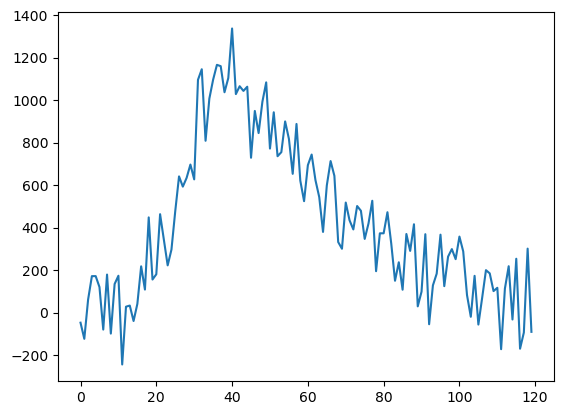

In [97]:
plt.plot(Y_sim.T)
plt.show()

## plots

(array([ 1.,  8., 16., 32., 42., 48., 35., 14.,  3.,  1.]),
 array([111.58344055, 116.68924422, 121.79504788, 126.90085155,
        132.00665522, 137.11245889, 142.21826256, 147.32406623,
        152.4298699 , 157.53567357, 162.64147724]),
 <BarContainer object of 10 artists>)

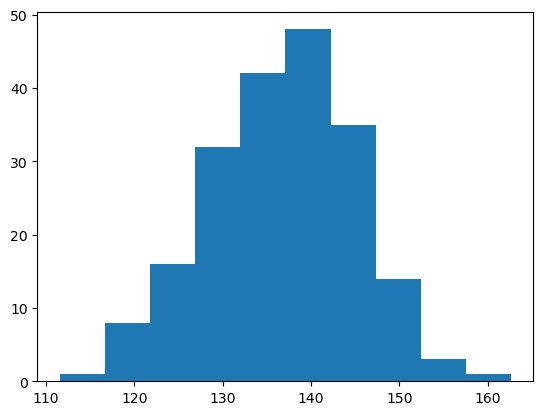

In [98]:
plt.hist(ssim_eps)

(array([ 5.,  9., 28., 40., 42., 30., 30.,  9.,  3.,  4.]),
 array([15.10942229, 15.75214343, 16.39486458, 17.03758572, 17.68030686,
        18.323028  , 18.96574915, 19.60847029, 20.25119143, 20.89391257,
        21.53663372]),
 <BarContainer object of 10 artists>)

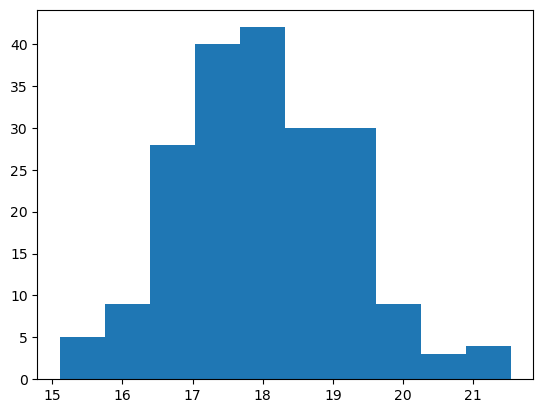

In [99]:
plt.hist(msim_0)

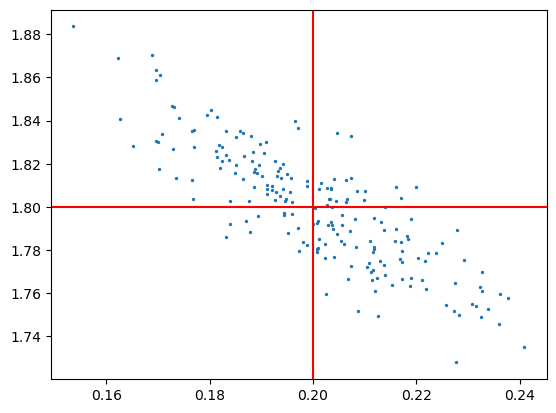

In [100]:
plt.scatter(bsim[:,0],bsim[:,1], s=2)
plt.axhline(y=beta[1], color='red')
plt.axvline(x=beta[0], color='red')

In [101]:
np.cov(bsim.T)

array([[ 0.00030027, -0.00040185],
       [-0.00040185,  0.00076107]])